# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [4]:
train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

### Model 1 : Conv3D

In [8]:
model1 = Sequential()

model1.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model1.add(Conv3D(64, kernel_size=3, activation='relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv3D(128, kernel_size=3, activation='relu'))
model1.add(MaxPooling3D(pool_size=(1, 2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model1.add(MaxPooling3D(pool_size=(1, 2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(GlobalAveragePooling3D())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(5, activation='softmax'))

2024-11-05 03:40:19.367289: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-05 03:40:19.367352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 128)    2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:5d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25


2024-11-05 03:40:23.692094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.3771 - categorical_accuracy: 0.3051
Epoch 00001: saving model to model_init_2024-11-0503_40_18.603889/model-    1-2.37714-0.30506-526.97290-0.17969.h5
21/21 [==============================] - 57s 3s/step - loss: 2.3771 - categorical_accuracy: 0.3051 - val_loss: 526.9729 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.8075 - categorical_accuracy: 0.3318
Epoch 00002: saving model to model_init_2024-11-0503_40_18.603889/model-    2-1.80752-0.33185-237.32295-0.19531.h5
21/21 [==============================] - 51s 3s/step - loss: 1.8075 - categorical_accuracy: 0.3318 - val_loss: 237.3230 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5481 - categorical_accuracy: 0.3884
Epoch 00003: saving model to model_init_2024-11-0503_40_18.603889/model-    3-1.54809-0.38839-75.18083-0.14844.h5
21/21 [======

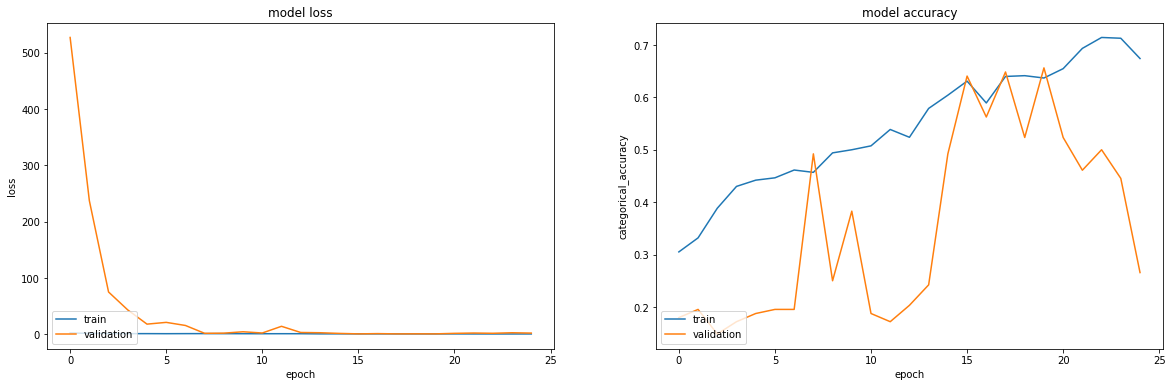

In [14]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model 2 : TimeDistributed Conv2D + GRU

In [15]:
model2 = Sequential()
model2.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model2.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model2.add(BatchNormalization())

model2.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model2.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model2.add(BatchNormalization())

model2.add(TimeDistributed(GlobalAveragePooling2D()))
model2.add(TimeDistributed(Dense(64, activation='relu')))
model2.add(BatchNormalization())

model2.add(GRU(128))
model2.add(BatchNormalization())
model2.add(Dense(5, activation='softmax'))

In [16]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 28, 28, 64)  

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:5d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.5483 - categorical_accuracy: 0.3854
Epoch 00001: saving model to model_init_2024-11-0503_40_18.603889/model-    1-1.54826-0.38542-2.21712-0.17969.h5
21/21 [==============================] - 53s 2s/step - loss: 1.5483 - categorical_accuracy: 0.3854 - val_loss: 2.2171 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.0999 - categorical_accuracy: 0.4911
Epoch 00002: saving model to model_init_2024-11-0503_40_18.603889/model-    2-1.09991-0.49107-1.54889-0.15625.h5
21/21 [==============================] - 50s 2s/step - loss: 1.0999 - categorical_accuracy: 0.4911 - val_loss: 1.5489 - val_categorical_accuracy: 0.1562 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.0343 - categorical_accuracy: 0.5253
Epoch 00003: saving model to model_init_2024-11-0503_40_18.603889/model-    3-1.03426-0.52530-1.56269-0.16406.h5
21/21 [====

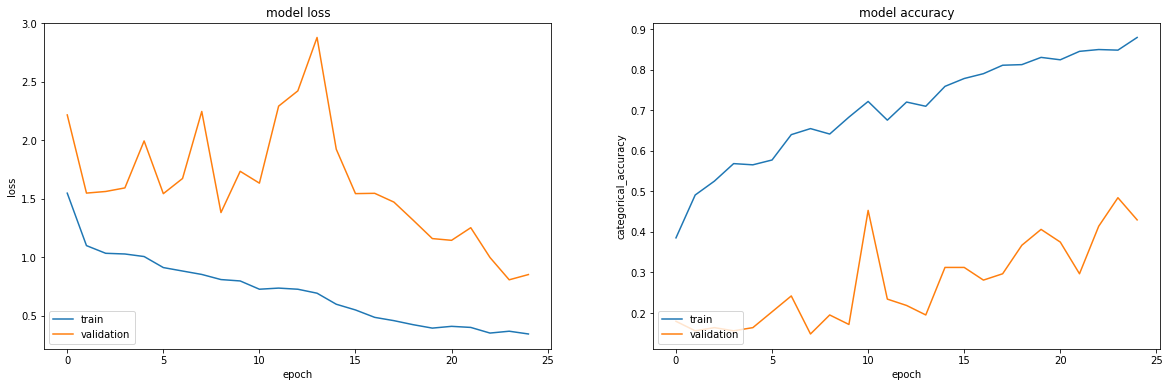

In [21]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model 3 : TimeDistributed Conv2D + GRU (Dropout=0.2)

In [22]:
model3 = Sequential()
model3.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model3.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model3.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(TimeDistributed(GlobalAveragePooling2D()))
model3.add(TimeDistributed(Dense(64, activation='relu')))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(GRU(128))
model3.add(BatchNormalization())
model3.add(Dense(5, activation='softmax'))

In [23]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 10, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 10, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                            

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:5d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.5930 - categorical_accuracy: 0.3616
Epoch 00001: saving model to model_init_2024-11-0503_40_18.603889/model-    1-1.59304-0.36161-1.97940-0.17969.h5
21/21 [==============================] - 53s 3s/step - loss: 1.5930 - categorical_accuracy: 0.3616 - val_loss: 1.9794 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.1765 - categorical_accuracy: 0.4568
Epoch 00002: saving model to model_init_2024-11-0503_40_18.603889/model-    2-1.17649-0.45685-2.08394-0.18750.h5
21/21 [==============================] - 50s 2s/step - loss: 1.1765 - categorical_accuracy: 0.4568 - val_loss: 2.0839 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.0667 - categorical_accuracy: 0.5327
Epoch 00003: saving model to model_init_2024-11-0503_40_18.603889/model-    3-1.06667-0.53274-1.87773-0.16406.h5
21/21 [====

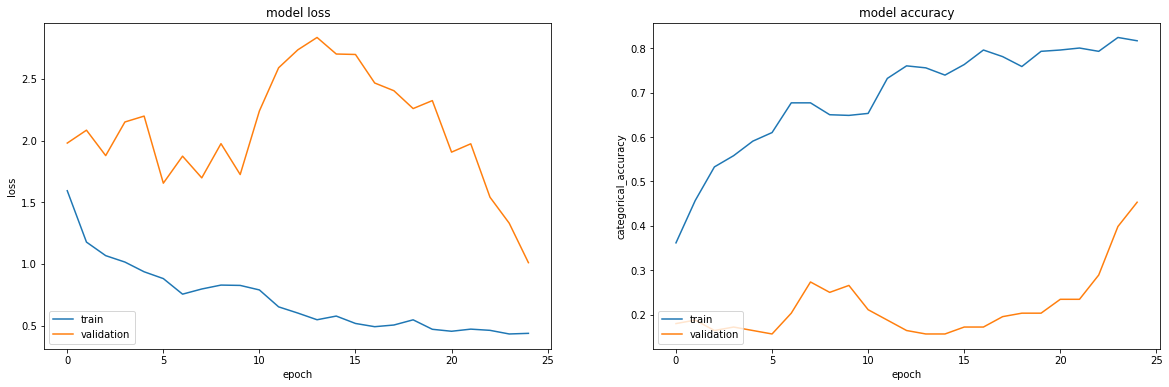

In [28]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model 4 : TimeDistributed Conv2D + Dense

In [29]:
model4 = Sequential()
model4.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model4.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model4.add(BatchNormalization())

model4.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model4.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model4.add(BatchNormalization())

model4.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model4.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model4.add(BatchNormalization())

model4.add(GlobalAveragePooling3D())
model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(5, activation='softmax'))

In [30]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 28, 28, 64)  

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:5d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6021 - categorical_accuracy: 0.4271
Epoch 00001: saving model to model_init_2024-11-0503_40_18.603889/model-    1-1.60207-0.42708-27.28418-0.17969.h5
21/21 [==============================] - 52s 3s/step - loss: 1.6021 - categorical_accuracy: 0.4271 - val_loss: 27.2842 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.1791 - categorical_accuracy: 0.5179
Epoch 00002: saving model to model_init_2024-11-0503_40_18.603889/model-    2-1.17914-0.51786-11.43412-0.21094.h5
21/21 [==============================] - 50s 2s/step - loss: 1.1791 - categorical_accuracy: 0.5179 - val_loss: 11.4341 - val_categorical_accuracy: 0.2109 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.0778 - categorical_accuracy: 0.5104
Epoch 00003: saving model to model_init_2024-11-0503_40_18.603889/model-    3-1.07780-0.51042-7.06034-0.16406.h5
21/21 [

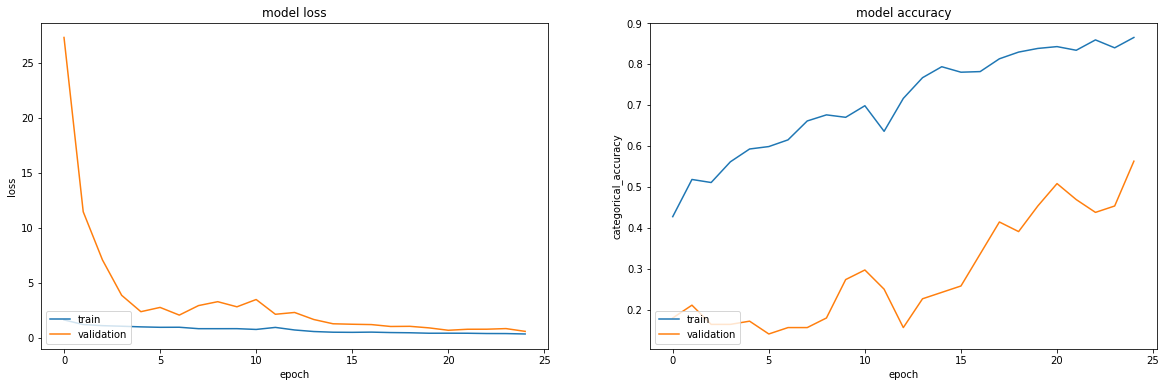

In [35]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model 5 : TimeDistributed + ConvLSTM2D

In [36]:
model5 = Sequential()
model5.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model5.add(BatchNormalization())
model5.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model5.add(BatchNormalization())
model5.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model5.add(BatchNormalization())
model5.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model5.add(BatchNormalization())
model5.add(GlobalAveragePooling2D())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(5, activation='softmax'))

In [37]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 10, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 10, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_19 (TimeDi  (None, 10, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_17 (Bat  (None, 10, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:5d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.4051 - categorical_accuracy: 0.3661
Epoch 00001: saving model to model_init_2024-11-0503_40_18.603889/model-    1-1.40506-0.36607-1.52283-0.17969.h5
21/21 [==============================] - 53s 3s/step - loss: 1.4051 - categorical_accuracy: 0.3661 - val_loss: 1.5228 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.1957 - categorical_accuracy: 0.4539
Epoch 00002: saving model to model_init_2024-11-0503_40_18.603889/model-    2-1.19572-0.45387-1.57442-0.13281.h5
21/21 [==============================] - 51s 3s/step - loss: 1.1957 - categorical_accuracy: 0.4539 - val_loss: 1.5744 - val_categorical_accuracy: 0.1328 - lr: 0.0100
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.1433 - categorical_accuracy: 0.4688
Epoch 00003: saving model to model_init_2024-11-0503_40_18.603889/model-    3-1.14326-0.46875-1.33267-0.17188.h5
21/21 [====

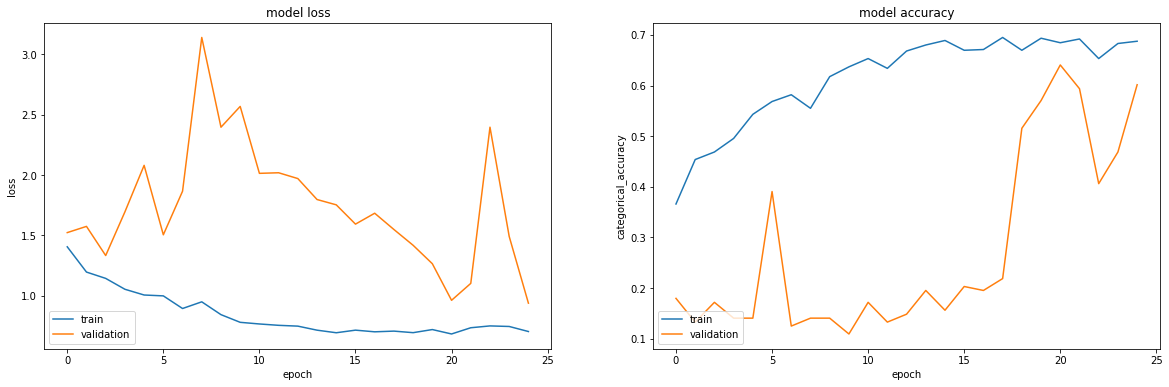

In [42]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')